In [1]:
cd C:\Users\syedd\Documents\mine\DCLC3

C:\Users\syedd\Documents\mine\DCLC3


In [2]:
import hydra
import lightning as pl
import omegaconf
from lightning import Callback, LightningDataModule, LightningModule, Trainer
import cv2
import numpy as np
import matplotlib.pyplot as plt
# import segmentation_models_pytorch as smp
from src.data.building_datasets import *

C:\Users\syedd\miniconda3\envs\openmmlab\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# cd C:\Users\syedd\Documents\mine\DCLC3\logs\train\runs\mask2former_swinsmall_top_561(shuffle)_aug\checkpoints

In [ ]:
ls *.ckpt

In [ ]:
cd C:\Users\syedd\Documents\mine\DCLC3


In [3]:
import os
from glob import glob 
ckpt_path=  "logs/train/runs/mask2former_swinsmall_top_561(shuffle)_aug/checkpoints/epoch_008.ckpt"
output_dir = "data/dataset/mask2former_swinsmall_top_561(shuffle)_aug_epoch_008_ckpt"
csv_path = "Submission Csv/mask2former_swinsmall_top_561(shuffle)_aug_epoch_008_ckpt"

images = glob("data/dataset/training_patches/*png")
masks = [i.replace("training_patches","training_noisy_labels") for i in images]
dataset = myInferDataset(images , masks)
infer_loader = DataLoader(dataset, batch_size=1,shuffle=False)

In [14]:
cfg = omegaconf.OmegaConf.load("../DCLC3/configs/model/building_seg.yaml")
model = hydra.utils.instantiate(cfg)

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-cityscapes-semantic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([20]) in the checkpoint and torch.Size([2]) in the model instantiated
- class_predictor.weight: found shape torch.Size([20, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([20]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.transformer_module.queries_embedder.weight: found shape torch.Size([100, 256]) in the checkpoint and torch.Size([1, 256]) in the model instantiated
- model.transformer_module.queries_features.weight: found shape torch.Size([100, 256]) in the checkpoint and torch.Size([1, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference

In [15]:
checkpoint = torch.load(ckpt_path, map_location="cpu")
print(checkpoint.keys())
model.load_state_dict(checkpoint["state_dict"], strict = True)
model.eval();

C:\Users\syedd\AppData\Local\Temp\ipykernel_5764\1006886086.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location="cpu")


dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters', 'datamodule_hparams_name', 'datamodule_hyper_parameters'])


In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_augmentation(image, mask):
    # Convert tensors back to numpy for visualization
    image_np = image.permute(1, 2, 0).numpy()  # HWC format
    mask_np = mask.squeeze(0).numpy()  # Remove channel dimension for grayscale

    # Create a red mask (3 channels)
    red_mask = np.zeros_like(image_np)  # Create an empty array with the same shape as the image
    red_mask[..., 0] = mask_np * 255  # Set red channel to mask values (255 for positive areas)

    # Use cv2.addWeighted for overlay
    overlay = cv2.addWeighted(image_np, 0.6, red_mask / 255.0, 0.4, 0)  # Blend with the original image

    # Display image and mask side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(image_np)
    axs[0].set_title('Image')
    axs[0].axis('off')
    
    axs[1].imshow(overlay)  # Show the overlay image
    axs[1].set_title('Overlayed Mask (in Red)')
    axs[1].axis('off')
    
    plt.show()

In [44]:
with torch.no_grad():
    i =0
    for image,mask,id1 in infer_loader:
        data_dict = {
            "pixel_values": image,
            "pixel_mask": mask.squeeze(1),
        }
        outputs = model.net(**data_dict)
        masks_queries_logits = outputs.masks_queries_logits
        
        logits = torch.nn.functional.interpolate(
            masks_queries_logits, 
            size=(256, 256), 
            mode="bilinear", 
            align_corners=False
        )
            
        preds = (torch.sigmoid(logits) > 0.2).float().squeeze(0)
        i+=1
        if i==2:
            break

In [45]:
mask.shape

torch.Size([1, 1, 256, 256])

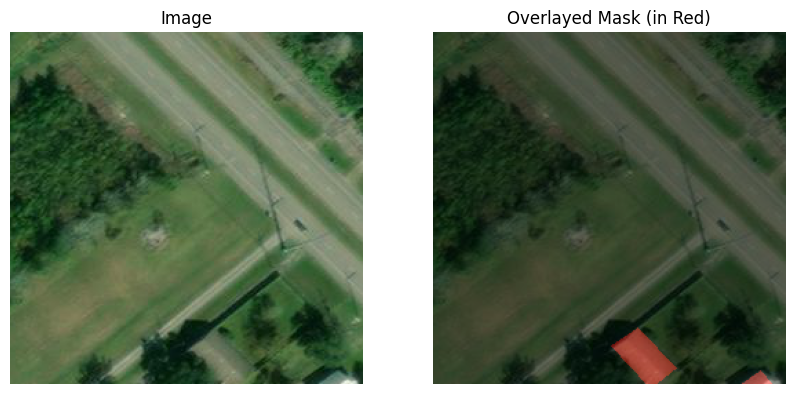

In [47]:
visualize_augmentation(image.squeeze(0) , mask)

In [ ]:
# Inference function
def infer_former(model, dataloader, out_dir ,device,threshold = 0.2):
    pred_list = []
    model.eval()  # Set the model to evaluation mode
    results_list = []  # To store image and loss pairs
    with torch.no_grad():  # Disable gradient computation
        for image, mask, image_id in tqdm(dataloader):
            output_path = out_dir+f'/{image_id[0]}'
            data_dict = {
            "pixel_values": image,
            "pixel_mask": mask.squeeze(1),
        }

            image = image.to(device)      # [batch_size, 3, 256, 256]
            mask = mask.to(device)        # [batch_size, 1, 256, 256]
            outputs = model(**data_dict)
            masks_queries_logits = outputs.masks_queries_logits
            
            logits = torch.nn.functional.interpolate(
            masks_queries_logits, size=(256, 256), mode="bilinear", align_corners=False
        )
            
            preds = (torch.sigmoid(logits) > 0.2)
            
            # pred_mask = (torch.sigmoid(outputs) > threshold).float()  # Binary mask [1, 1, 256, 256]
            # intersection = (pred_mask * mask).sum()
            # union = pred_mask.sum() + mask.sum() - intersection
            # iou = (intersection / (union + 1e-6)).cpu().numpy()  # Add small value to avoid division by zero

            # pred_mask = pred_mask.squeeze(0).squeeze(0)
            # binary_mask = pred_mask.cpu().numpy()  # Convert to numpy array
            # binary_mask = (np.stack([binary_mask] * 3, axis=-1))          
            
            # pred_list.append([image_id[0] ,iou])
            # os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
            # # Save the predicted mask
            # cv2.imwrite(output_path, binary_mask)
            break;
    return pred_list

In [ ]:
preds

In [ ]:
# Inference function
def infer(model, dataloader, out_dir ,device,threshold = 0.2):
    pred_list = []
    model.eval()  # Set the model to evaluation mode
    results_list = []  # To store image and loss pairs
    with torch.no_grad():  # Disable gradient computation
        for image, mask, image_id in tqdm(dataloader):
            output_path = out_dir+f'/{image_id[0]}'

            image = image.to(device)      # [batch_size, 3, 256, 256]
            mask = mask.to(device)        # [batch_size, 1, 256, 256]
            outputs = model(image)
            pred_mask = (torch.sigmoid(outputs) > threshold).float()  # Binary mask [1, 1, 256, 256]
            intersection = (pred_mask * mask).sum()
            union = pred_mask.sum() + mask.sum() - intersection
            iou = (intersection / (union + 1e-6)).cpu().numpy()  # Add small value to avoid division by zero

            pred_mask = pred_mask.squeeze(0).squeeze(0)
            binary_mask = pred_mask.cpu().numpy()  # Convert to numpy array
            binary_mask = (np.stack([binary_mask] * 3, axis=-1))          
            
            pred_list.append([image_id[0] ,iou])
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
            # Save the predicted mask
            cv2.imwrite(output_path, binary_mask)
    return pred_list

In [ ]:
from torch.utils.data import DataLoader
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
preds = infer_former(model.to(Device) , infer_loader , output_dir , Device , threshold = 0.2)

In [ ]:
df = pd.DataFrame(preds, columns=["image_id","iou"])
# df.loc[df['iou'] == 0, 'iou'] = 1
df = df.sort_values("iou", ascending=False).reset_index(drop=True)
df["id"] = df.index
df_iou = df[["iou", "image_id"]]
df_sub = df[["id", "image_id"]]

In [ ]:
df_iou.head() , df_sub.head()

In [ ]:
df_sub.to_csv(f"{csv_path}.csv", index=False)
df_iou.to_csv(f"{csv_path}_raw.csv", index=False)


#### Merge two models

In [ ]:
df_sub.to_csv("Submission Csv/prev_best+top_561_epoch_030_raw.csv", index=False)
df_iou.to_csv("Submission Csv/dlv3+_resnet101_top_561_unshuffled_aug(more)_epoch_017_ckpt_raw.csv", index=False)


In [ ]:
import pandas as pd
df1 = pd.read_csv("Submission Csv/dlv3+_resnet101_top_292_aug(more)_epoch_020_ckpt_raw.csv")
df2 = pd.read_csv("Submission Csv/dlv3+_resnet101_top_292_aug(more)_last_ckpt_raw.csv")
df3 = pd.read_csv("Submission Csv/merge_top_3(1)_raw.csv")

df4 = df1.merge(df2, on="image_id", suffixes=('_1', '_2')).merge(df3, on="image_id")
df4.rename(columns={'iou': 'iou_3'}, inplace=True)

# Calculate the average `iou` for each `image_id`
df4['iou_avg'] = df4[['iou_1', 'iou_2', 'iou_3']].mean(axis=1)
df4 = df4[['image_id', 'iou_avg']]
df4 = df4.sort_values("iou_avg", ascending=False).reset_index(drop=True)
df4["id"] = df.index
df_iou = df4[["iou_avg", "image_id"]]
df_sub = df4[["id", "image_id"]]

# Create the final dataframe with `image_id` and `iou_avg`



#### TOP2 csvs

In [ ]:
df1 = pd.read_csv("Submission Csv/prev_best+top_561_epoch_030_raw.csv")
df2 = pd.read_csv("Submission Csv/dlv3+_resnet101_top_561_unshuffled_aug(more)_epoch_017_ckpt_raw.csv")


In [ ]:
df2.head()

In [ ]:
df4 = pd.merge(df1, df2, on='image_id', suffixes=('_df1', '_df2'))
df4['iou'] = df4[['iou_df1', 'iou_df2']].mean(axis=1)
df4 = df4[['iou', 'image_id']]
df4 = df4.sort_values("iou", ascending=False).reset_index(drop=True)
df4["id"] = df.index

df_iou = df4[["iou", "image_id"]]
df_sub = df4[["id", "image_id"]]


In [ ]:
df_iou.head()

In [ ]:
df_sub.to_csv("Submission Csv/prev_best+top_561(only)_unshuffled.csv", index=False)
df_iou.to_csv("Submission Csv/prev_best+top_561(only)_unshuffled_raw.csv", index=False)


#### Analysis on Val dataset

In [ ]:
data_dir = "data/dataset/New_dataset/Images"

In [ ]:
images = glob(f"{data_dir}/*jpg")
val_image = images[(int)(0.8*len(images)):]
val_masks = [i.replace("Images" , "Masks").replace("jpg","tif") for i in val_image]

In [ ]:
len(val_image),len(val_masks)

***CHECKING

In [ ]:
def visualize_augmentation(image, mask):
    # Convert tensors back to numpy for visualization
    image_np = image.permute(1, 2, 0).numpy()  # HWC format
    mask_np = mask.squeeze(0).numpy()  # Remove channel dimension for grayscale

    # Create a red mask (3 channels)
    red_mask = np.zeros_like(image_np)  # Create an empty array with the same shape as the image
    red_mask[..., 0] = mask_np * 255  # Set red channel to mask values (255 for positive areas)

    # Use cv2.addWeighted for overlay
    overlay = cv2.addWeighted(image_np, 0.6, red_mask / 255.0, 0.4, 0)  # Blend with the original image

    # Display image and mask side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(image_np)
    axs[0].set_title('Image')
    axs[0].axis('off')
    
    axs[1].imshow(overlay)  # Show the overlay image
    axs[1].set_title('Overlayed Mask (in Red)')
    axs[1].axis('off')
    
    plt.show()

INFERENCE

In [ ]:
import os
import csv
import torch
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

# Define directories
output_dir = "data/dataset/New_dataset/New_Pred_Masks"
image_patch_dir = "data/dataset/New_dataset/image_patch"
mask_patch_dir = "data/dataset/New_dataset/mask_patch"

# os.makedirs(output_dir, exist_ok=True)

csv_file = "results_id_iou.csv"
threshold = 0.65
# Create dataset and dataloader
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Run inference and save results
results = []
with torch.no_grad():
    for i, (image_patch, mask_patch,image_id) in enumerate(tqdm(dataloader)):

        # Get model prediction
        pred_patch = model(image_patch)
        pred_mask = (torch.sigmoid(pred_patch) > threshold).float()  # Threshold the outputs
        intersection = (pred_mask * mask_patch).sum(dim = [1,2,3])
        union = pred_mask.sum(dim = [1,2,3]) + mask_patch.sum(dim = [1,2,3]) - intersection
        iou = (intersection / (union + 1e-6)).mean()
        
        pred_mask = pred_mask.cpu().numpy()[0, 0]  # Convert to NumPy array
        
        output_path = output_dir + f"/{i}{image_id[0]}"
        image_patch_path = image_patch_dir + f"/{i}{image_id[0]}"
        mask_patch_path = mask_patch_dir + f"/{i}{image_id[0]}"

        
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        os.makedirs(os.path.dirname(image_patch_path), exist_ok=True)
        os.makedirs(os.path.dirname(mask_patch_path), exist_ok=True)

        
        cv2.imwrite(output_path, pred_mask)
        cv2.imwrite(image_patch_path, image_patch.squeeze(0).permute(1,2,0).numpy()*255)
        cv2.imwrite(mask_patch_path, mask_patch.squeeze(0).permute(1,2,0).numpy())

        # Append results
        iou = iou.numpy()
        results.append([f"{i}{image_id[0]}", iou])
        

In [ ]:
len(results)

In [ ]:
# Write results to CSV
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["image_id", "iou"])
    writer.writerows(results)

print(f"Saved predicted masks to {output_dir} and results to {csv_file}")

In [ ]:
# visualize_augmentation(image,preds)

In [ ]:
# visualize_augmentation(image,mask)

In [ ]:
preds

# Efficient ViT

In [ ]:
cd C:/Users/syedd/Documents/mine/DCLC3/mmsegmentation

In [ ]:
!python --version


In [ ]:
!git clone https://github.com/open-mmlab/mmsegmentation.git

In [ ]:
!pip install -r requirements.txt

In [ ]:
from tools.model_converters import vit2mmseg

In [ ]:
!pip install -r albu.txt mminstall.txt multimodal.txt optional.txt readthedocs.txt runtime.txt tests.txt

In [ ]:
!which python 
